# DISQ for execution of VQA on noisy devices

## Method objective and applicability

DISQ ([paper](http://arxiv.org/abs/2308.06634)) is an evolution of QISMET ([paper](http://arxiv.org/abs/2209.12280)).

It is a method designed to provide better convergence to VQA (incl. VQE and QAOA) in presence of hardware noise.

Specifically, it addresses "noise drift", namely "deviations in a quantum circuit's output distribution caused by shifts in the device characteristics of one or more qubits in the quantum circuit", as an effect of time passing between one iteration and the next one in hybrid-classical methods.

"Since noise drift alters the VQA tuning landscape over iterations, it leads to inconsistent gradient estimation each time and thus disrupts the convergence of VQA."


## Method description

At each iteration, some additional "reference" circuits are appended to the job. "Noise drift errors are assessed by comparing the energy of the references in previous jobs with their repetitions in the current job". If reference circuits are performing too differently from the previous iterations, then the current iteration is rejected and repeated.

Multiple reference circuits are used, as this improves the performance of the algorithm -- see Fig. 5 and Sec. IV-A in the paper.

In order to reduce the overhead of the additional circuits, only the leading Pauli terms in the Hamiltonian are used for reference, thus decreasing the number of observables (see Sec IV-B).

For more details refer to the original [paper](http://arxiv.org/abs/2308.06634).

## Implementation

The code in the `DISQ-main` subfolder is simply a copy of the [authors' repo](https://github.com/JJJayyyy/DISQ), which is licensed under MIT.

The program structure is sketched below.

### main.py
The file `main.py` collects necessary information and calls the algorithm.

The preparation method uploads the method file `mitigation_method.py`, see line 58:
```
                    service.update_program(program_id=program_id, data=script_path, metadata=metadata)

```
It can be convenient to give an appropriate `program_id` in line 54:
```
            program_id = 'transient-noise-mitigation-JWjoXe5XgM'    # replace with yours

```

Then, the main execution line is 146:

```
        job = service.run(program_id=program_id, inputs=vqe_inputs, options={"backend_name": backend.name})
```

### mitigation_method.py

The method is contained in this file. The implementation relies on a custom-written SPSA optimizer.


### Interesting options
The optimizer takes the following interesting options, which unfortunately are not further documented, see line 183 of `main.py`:

```
    # optimizer arguments
    parser.add_argument('--optimizer', default='DISQ', choices=['DISQ', 'SPSA'], help='Disq or SPSA optimizers')
    parser.add_argument('--method', default='amp_p', choices=['amp_a', 'amp_p', 'grad'], 
                        help='amplitude method or gradient method')
    parser.add_argument('--cal_c', type=float, default=0.2, help='set c value in calibrate')
    parser.add_argument('--cal_a', type=float, default=0.9, help='set alpha value in calibrate')

    # transient noise arguments
    parser.add_argument('--factor', type=float, default=0, help='set transient noise factor')
    parser.add_argument('--threshold', type=float, default=0.9, help='set transient noise threshold')
    parser.add_argument('--prime_th', type=float, default=0.8, help='set prime threshold')
```

### How to run an example problem

To run an example instance, simply follow the README to setup the env and launch `main.py`.

**[TODO]** Some fixes are required due to deprecation of some qiskit features:
- we should check if programs already available in qiskit runtime are equivalent to this one, or otherwise upload it
- cloud simulator are deprecated, on hw everything should work, but testing on simulators in not easy...
- something was wrong in `Utils.py`, method `get_service()`; I've commented few lines.

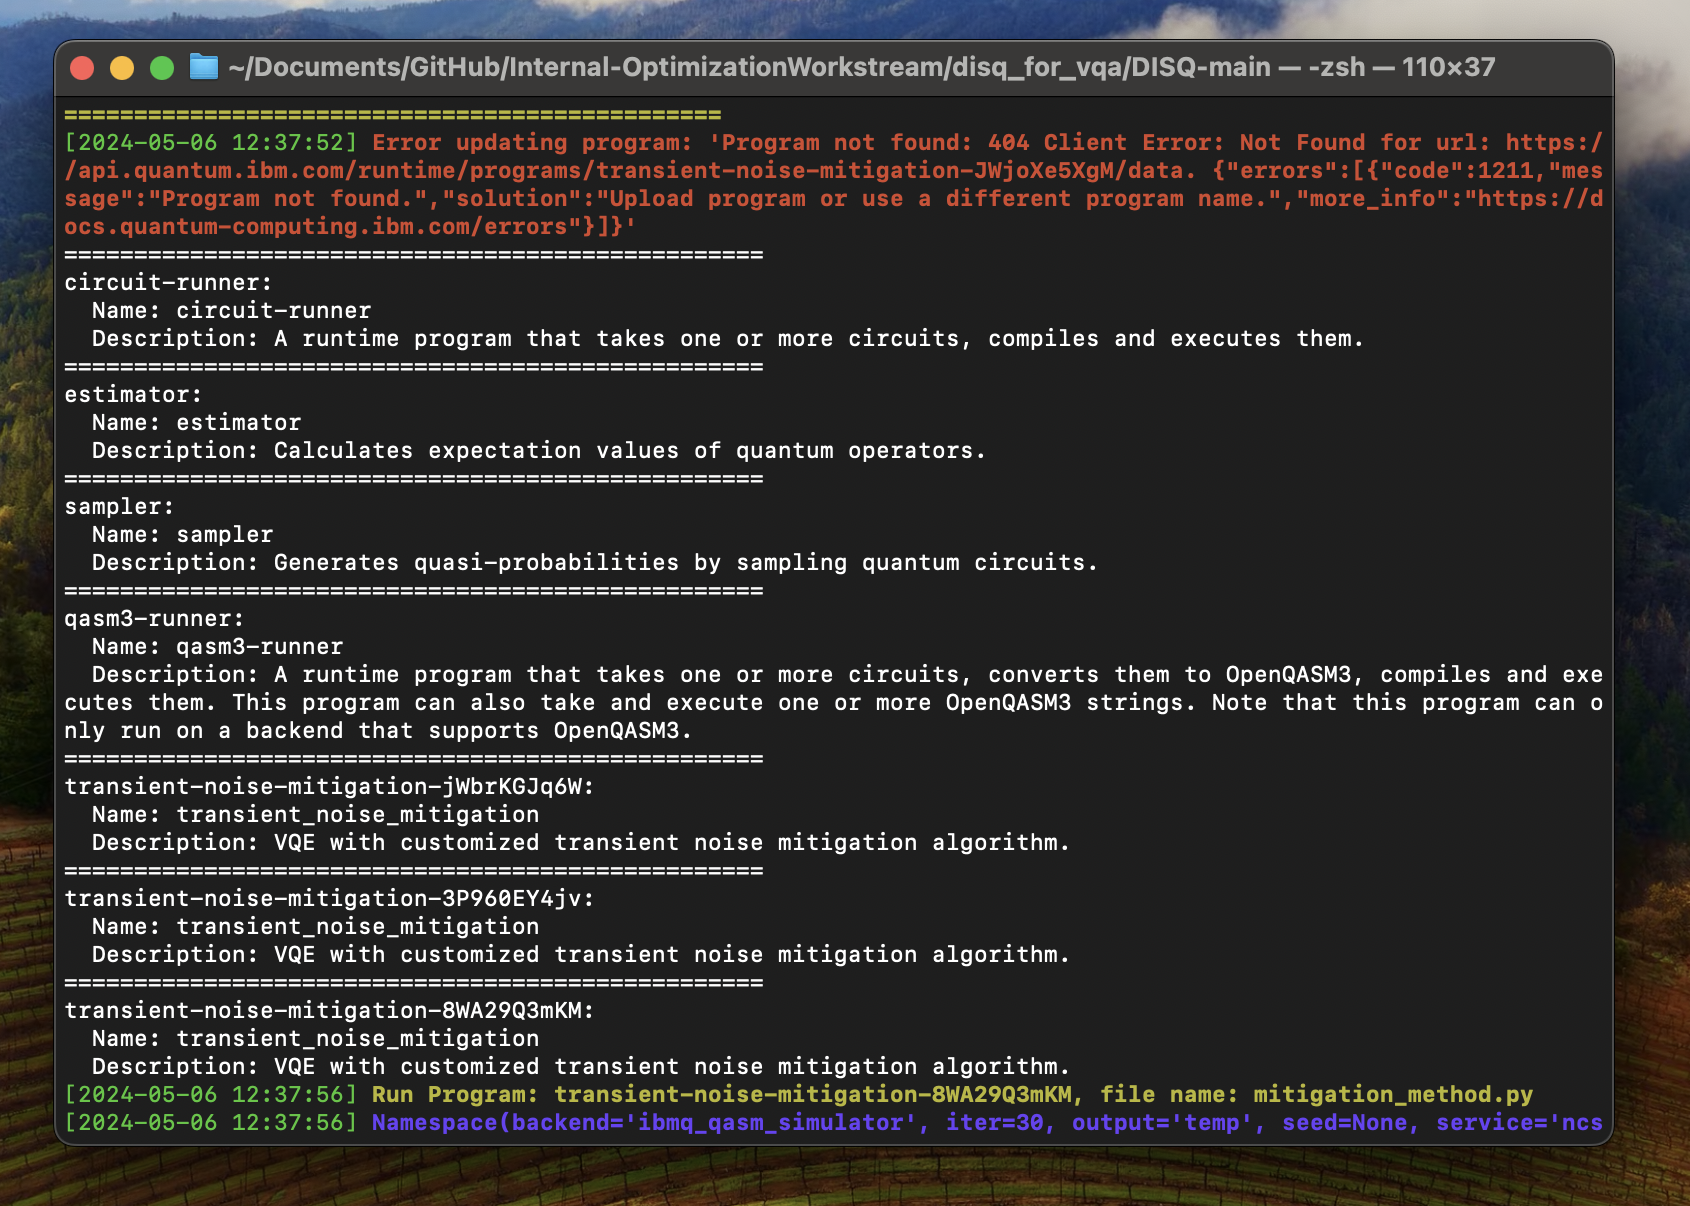

### How to run your own problem

Examples are based on molecule simulation, and allow the ansatz to be `EfficientSU2` or `RealAmplitudes`.

Anyway, replacing the Hamiltonian and the variational form with whatever you like, should be straight-forward, once TODO's above are done. Simply set the `vqe_inputs` as you like at line 126 of `main.py`:

```
    vqe_inputs = {
        "ansatz": var_form,
        "operator": qubit_op,
        "initial_point": initial_point,
        "shots": 1024,
        "iteration": args.iter,
        "output_dir": str(output_path),
        "seed": args.seed,
        "optimizer": args.optimizer,
        "factor": args.factor,
        "c": args.cal_c,
        "alpha": args.cal_a,
        "prime_th": args.prime_th,
        "threshold": args.threshold,
        "method": args.method,
    }
```
